In [2]:
import os
os.listdir('train')

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [4]:
#hàm để gán nhãn cho hình và đầu ra là loại hoa
def assign_label(img,flower_type):
    return flower_type

In [3]:
# Bỏ qua các cảnh báo
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#chọn mẫu
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#trước khi xử lý
from keras.preprocessing.image import ImageDataGenerator

#tư viện dl
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

#  Convolutional Neural Network
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

import tensorflow as tf
import random as rn

# xử lý hình ảnh nén và nhận các mảng phức tạp về giá trị pixel của hình ảnh. 
import cv2                  
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

In [80]:
X=[]
Y=[]
INPUT_SIZE=150
DAISY_DIR='train/daisy'
SUNFLOWER_DIR='train/sunflower'
TULIP_DIR='train/tulip'
DANDI_DIR='train/dandelion'
ROSE_DIR='train/rose'

In [81]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,flower_type)
        path = os.path.join(DIR,img)
        #imread() trả về ma trận 2D hoặc 3D dựa trên số lượng màu có trong hình ảnh.
        #inread_color() đọc ảnh màu RGB
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        #Scale ảnh về size 150X150
        img = cv2.resize(img, (INPUT_SIZE, INPUT_SIZE))
        #thêm mảng img vào list X[]
        X.append(np.array(img))
        #list Z bao gồm thông tin label (img,hàm flower type)
        Y.append(str(label))

In [82]:
make_train_data('sunflower',SUNFLOWER_DIR)
print(len(X))
make_train_data('daisy',DAISY_DIR)
print(len(X))
make_train_data('tulip',TULIP_DIR)
print(len(X))
make_train_data('dandelion',DANDI_DIR)
print(len(X))
make_train_data('rose',ROSE_DIR)
print(len(X))

100%|██████████| 495/495 [00:03<00:00, 162.22it/s]


495


100%|██████████| 501/501 [00:02<00:00, 167.28it/s]


996


100%|██████████| 607/607 [00:03<00:00, 167.34it/s]


1603


100%|██████████| 646/646 [00:03<00:00, 170.46it/s]


2249


100%|██████████| 497/497 [00:02<00:00, 174.48it/s]

2746


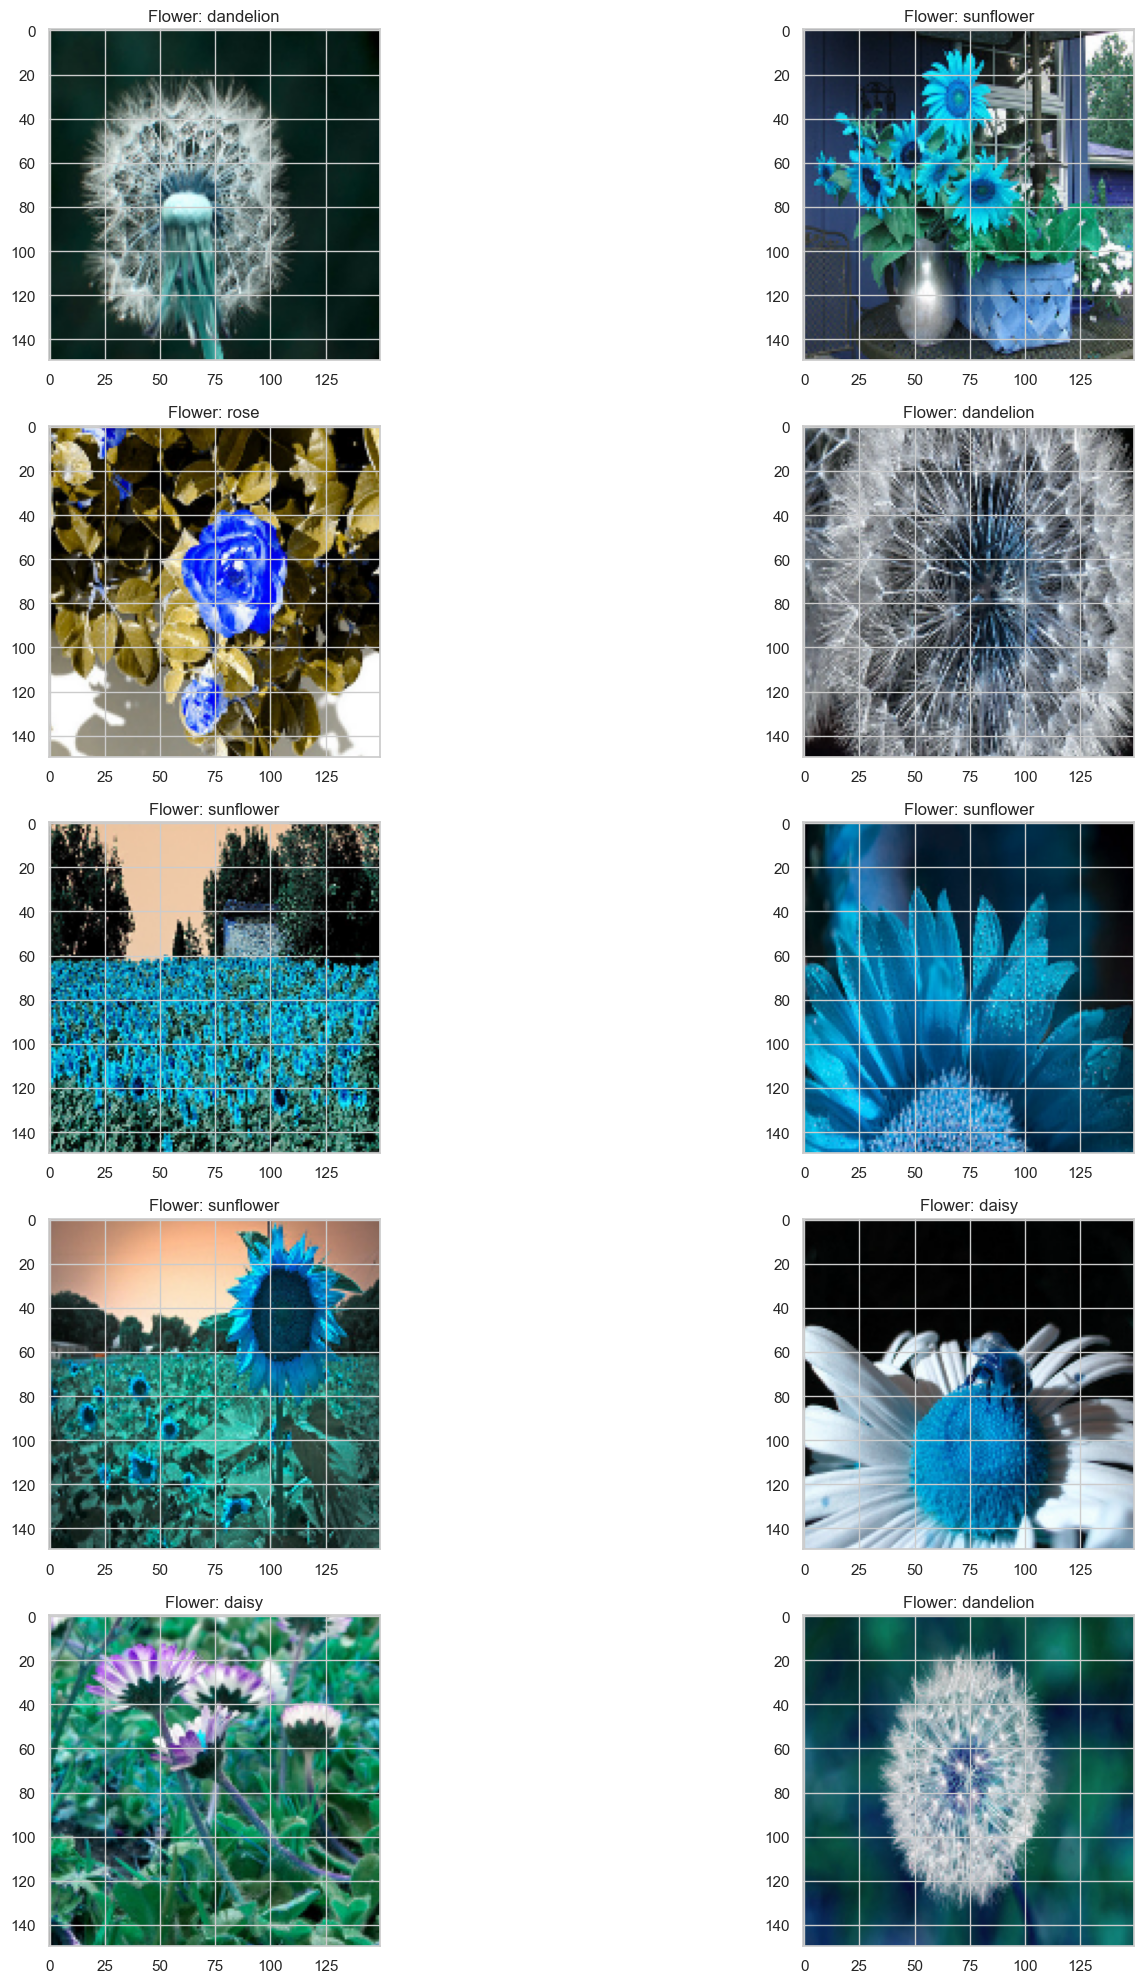

In [83]:
fig,ax=plt.subplots(5,2) 
fig.set_size_inches(20,20)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Y))# chạy trong khoảng từ 0 đến giá trị của Z
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Y[l])
plt.tight_layout()

In [84]:
le=LabelEncoder()
Z=le.fit_transform(Y)
Z=to_categorical(Z,5) #5 ma trận 5x5
X=np.array(X)
X=X/255

In [85]:
xtrain, xtest, ytrain, ytest=train_test_split(X, Z, test_size=0.2, random_state=0)
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [86]:
from keras.layers import Conv2D, MaxPooling2D,InputLayer

In [120]:
model = Sequential()
# Đây là hàm khai báo việc tạo một model. Model được tạo có dạng liên tiếp, 
#nghĩa là các lớp (layer) nối tiếp nhau. Hàm này nhận vào một list các layer.

model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
# maxpoolong2D làm giảm param trong ảnh nhưng vẫn giữ lại đặc trưng
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 

model.add(Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#Flatten chuyển ma trận thành mảng
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
#layer có 5 node và hàm activation là softmax
model.add(Dense(5, activation = "softmax"))

In [121]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # đặt giá trị đầu vào thành 0 trên tập dữ liệu
        samplewise_center=False,  # đặt giá trị trung bình của mỗi mẫu thành 0
        featurewise_std_normalization=False,  # chia đầu vào cho std của tập dữ liệu
        samplewise_std_normalization=False,  # chia mỗi đầu vào cho std của nó
        zca_whitening=False,  # bôi ZCA làm trắng
        rotation_range=10,  # xoay ngẫu nhiên hình ảnh trong phạm vi (độ, 0 đến 180)
        zoom_range = 0.1,  # Hình ảnh thu phóng ngẫu nhiên 
        width_shift_range=0.2,  # dịch chuyển ngẫu nhiên hình ảnh theo chiều ngang (một phần nhỏ của tổng chiều rộng)
        height_shift_range=0.2,  # dịch chuyển ngẫu nhiên hình ảnh theo chiều dọc (một phần của tổng chiều cao)
        horizontal_flip=True,  # hình ảnh lật ngẫu nhiên
        vertical_flip=False)  # hình ảnh lật ngẫu nhiên


datagen.fit(xtrain)

In [122]:
batch_size=16 #thể hiện số lượng mẫu sử dụng cho mỗi lần cập nhật trọng số .
epochs=11 #số lần duyệt qua hết số lượng mẫu trong tập huấn luyện.

from keras.callbacks import ReduceLROnPlateau #giảm learning mỗi khi metrics không cải thiện
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

In [123]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 150, 150, 32)      2432      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 18, 18, 96)      

In [124]:
Model = model.fit(xtrain, ytrain, batch_size=16, verbose=1, epochs=11, validation_data=(xtest, ytest), shuffle=False)

Epoch 1/11
138/138 [==============================] - 34s 240ms/step - loss: 1.3703 - accuracy: 0.3930 - val_loss: 1.2342 - val_accuracy: 0.4109
Epoch 2/11
138/138 [==============================] - 32s 232ms/step - loss: 1.1205 - accuracy: 0.5414 - val_loss: 1.1222 - val_accuracy: 0.5164
Epoch 3/11
138/138 [==============================] - 32s 232ms/step - loss: 0.9676 - accuracy: 0.6084 - val_loss: 0.9606 - val_accuracy: 0.6364
Epoch 4/11
138/138 [==============================] - 33s 238ms/step - loss: 0.8153 - accuracy: 0.6726 - val_loss: 1.2372 - val_accuracy: 0.5855
Epoch 5/11
138/138 [==============================] - 31s 223ms/step - loss: 0.6696 - accuracy: 0.7482 - val_loss: 1.3287 - val_accuracy: 0.5945
Epoch 6/11
138/138 [==============================] - 31s 227ms/step - loss: 0.5089 - accuracy: 0.8174 - val_loss: 1.2571 - val_accuracy: 0.5891
Epoch 7/11
138/138 [==============================] - 30s 221ms/step - loss: 0.4016 - accuracy: 0.8561 - val_loss: 1.8780 - val_ac

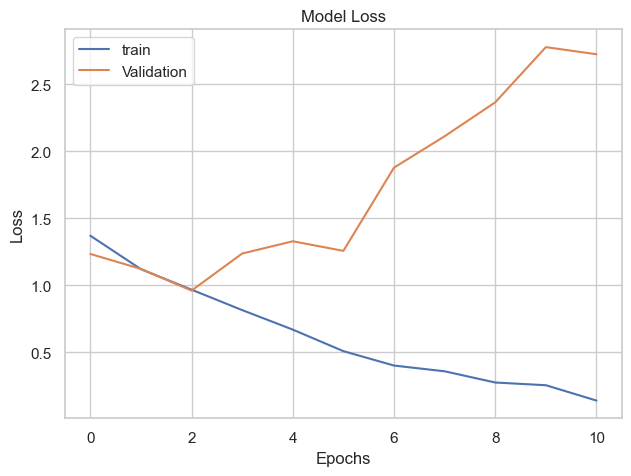

In [125]:
plt.plot(Model.history['loss'])
plt.plot(Model.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train','Validation'])
plt.show()

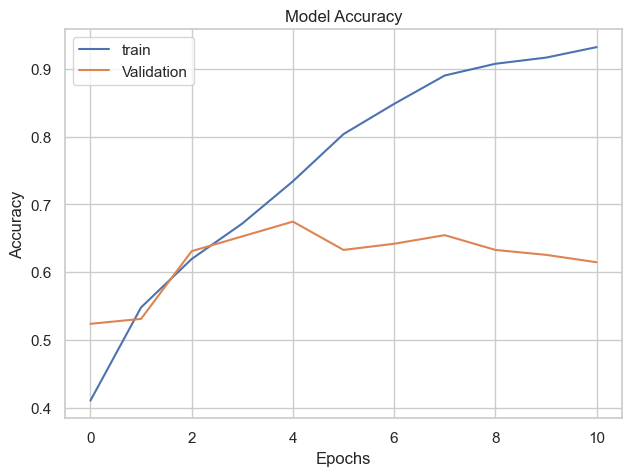

In [93]:
plt.plot(Model.history['accuracy'])
plt.plot(Model.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')#độ chính xác
plt.xlabel('Epochs') #thời gian
plt.legend(['train','Validation'])
plt.show()

In [95]:
pred=model.predict(xtest)
pred_digits=np.argmax(pred,axis=1)

18/18 [==============================] - 2s 84ms/step


In [96]:
# hiện đang lưu trữ một số chỉ mục đúng cách cũng như phân loại sai '. 
i=0
prop_class=[]
mis_class=[]

for i in range(len(ytest)):
    if(np.argmax(ytest[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

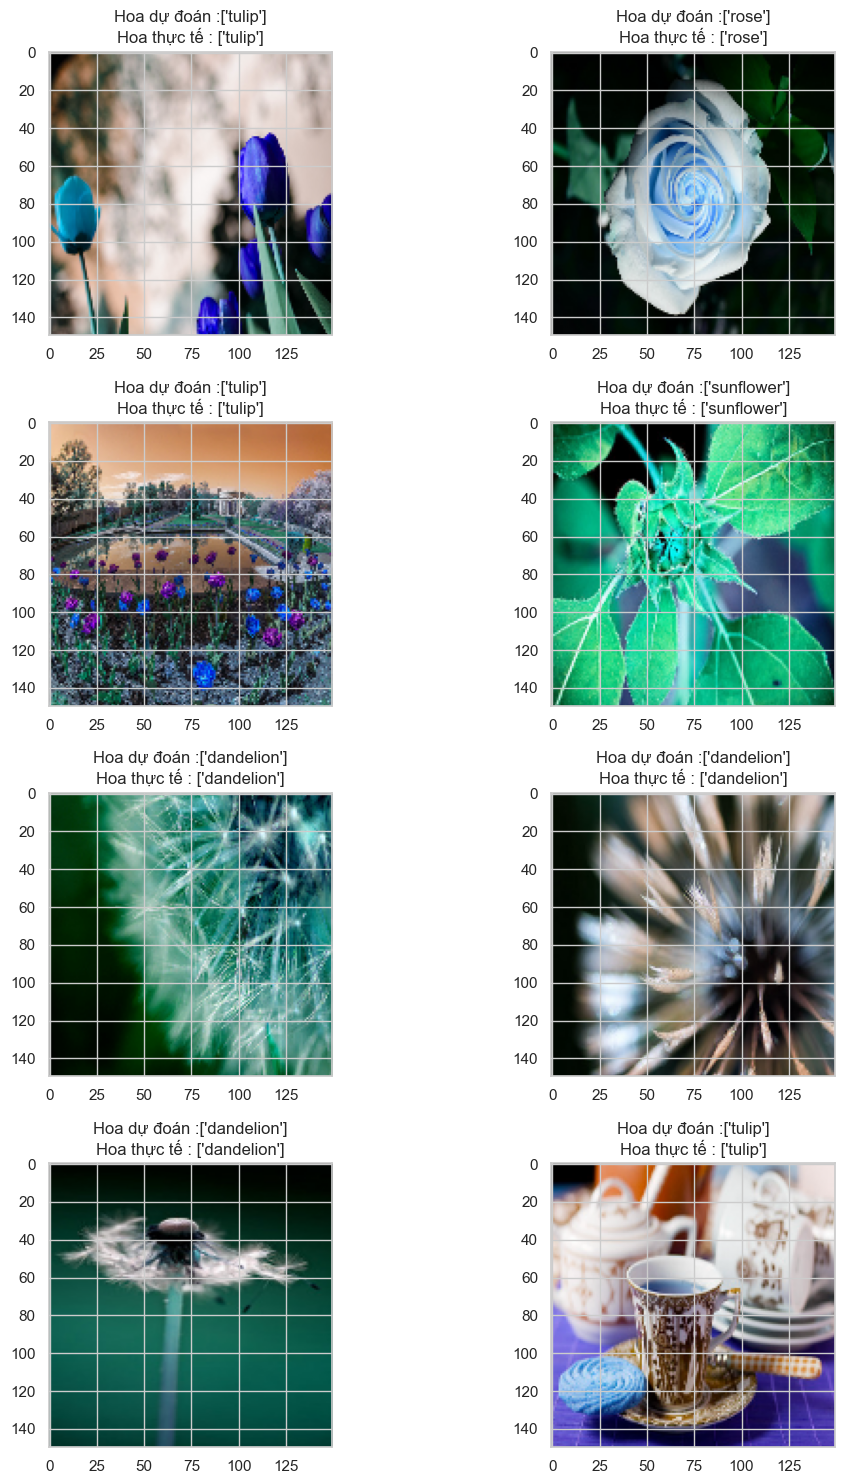

In [128]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)

for i in range (4):
    for j in range (2):
        ax[i,j].imshow(xtest[prop_class[count]])
        ax[i,j].set_title("Hoa dự đoán :"+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"
                  +"Hoa thực tế : "+str(le.inverse_transform([np.argmax(ytest[prop_class[count]])])))
        plt.tight_layout()
        count+=1

In [129]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score


pred=(pred>0.01) .astype (int)
y_true=np.reshape (ytest, [-1])
y_pred=np.reshape (pred, [-1])
#Evaluation index
accuracy=accuracy_score (y_true, y_pred)
precision=precision_score (y_true, y_pred)
recall=recall_score (y_true, y_pred, average="binary")
f1score=f1_score (y_true, y_pred, average="binary")

[Text(0.5, 1.0, 'Đánh giá độ chính xác CNN')]

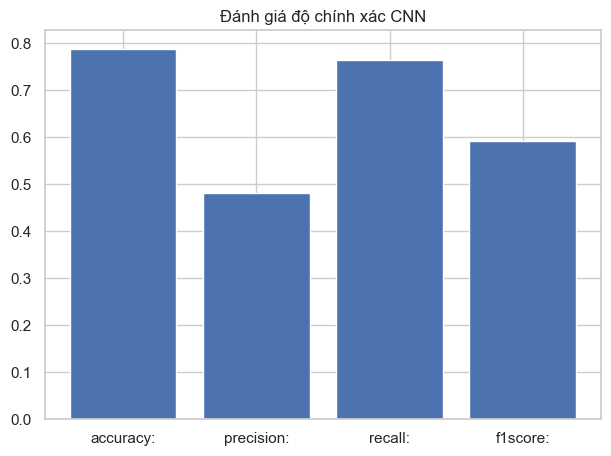

In [130]:
evaluation = {
    "accuracy:" :accuracy,
    "precision:" :precision,
    "recall:": recall,
    "f1score:": f1score
}
fig, ax = plt.subplots()
ax.bar(evaluation.keys(), evaluation.values())
ax.set(title="Đánh giá độ chính xác CNN")

In [100]:
x_test=[]

In [103]:
def make_test_data(DIR):
    for img in tqdm(os.listdir(DIR)):
        label=[]
        path = os.path.join(DIR,img)
        #imread() trả về ma trận 2D hoặc 3D dựa trên số lượng màu có trong hình ảnh.
        #inread_color() đọc ảnh màu RGB
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (150,150))
        x_test.append(np.array(img))

In [105]:
FLOWER = 'test'
make_test_data(FLOWER)


100%|██████████| 924/924 [00:06<00:00, 150.30it/s]


In [106]:
unlabeled_data = np.array(x_test)
x_test = unlabeled_data/255

In [126]:
predictions=model.predict(x_test)
pred_digits_test=np.argmax(predictions,axis=1)

29/29 [==============================] - 3s 93ms/step


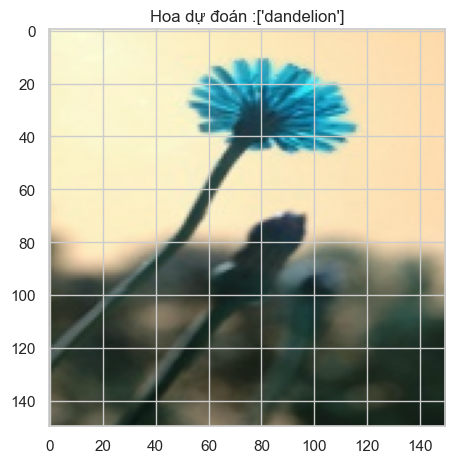

In [127]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

plt.imshow(x_test[24])
plt.title("Hoa dự đoán :"+str(le.inverse_transform([pred_digits_test[1]])))
plt.tight_layout()